In [9]:
# Train the CNN Genre Classification Model#
# Last editted by Pu Zeng, 18/10/2023 #

In [1]:
import os
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
# import mido
import string
import numpy as np
# from utilis import get_pianoroll_data
import pickle
import os
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
# import mido
import string
import numpy as np
# from utilis import get_pianoroll_data
import pickle
from sklearn import preprocessing
import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #Define device
input_dir = '../Toy_Dataset/adl-piano-midi/' #Please change
output_dir = './Processed_Data/'

In [8]:
!python ../Data_Preprocessing/Piano_Genre_Classification.py ../Toy_Dataset/adl-piano-midi/ ./Processed_Data/
# It takes some time

All content numbers is 18



0it [00:00, ?it/s]
1it [00:00,  2.43it/s]
2it [00:00,  2.42it/s]
3it [00:01,  3.06it/s]
4it [00:01,  3.84it/s]
5it [00:01,  4.48it/s]
6it [00:01,  3.33it/s]
7it [00:02,  2.82it/s]
8it [00:02,  2.55it/s]
9it [00:02,  3.29it/s]
10it [00:02,  4.04it/s]
11it [00:03,  4.53it/s]
12it [00:03,  4.95it/s]
13it [00:03,  5.44it/s]
15it [00:03,  7.78it/s]
16it [00:03,  7.93it/s]
17it [00:03,  8.08it/s]
18it [00:03,  8.18it/s]
19it [00:04,  8.25it/s]
20it [00:04,  8.30it/s]
21it [00:04,  7.42it/s]
22it [00:04,  6.63it/s]
23it [00:04,  6.45it/s]
24it [00:04,  6.34it/s]
25it [00:05,  6.09it/s]
26it [00:05,  5.77it/s]
27it [00:05,  5.84it/s]
28it [00:05,  5.68it/s]
29it [00:05,  5.75it/s]
30it [00:05,  5.32it/s]
31it [00:06,  5.34it/s]
32it [00:06,  5.47it/s]
33it [00:06,  5.24it/s]
34it [00:06,  5.15it/s]
35it [00:06,  4.84it/s]
36it [00:07,  4.88it/s]
37it [00:07,  4.97it/s]
38it [00:07,  5.18it/s]
39it [00:07,  5.06it/s]
40it [00:07,  5.24it/s]
41it [00:08,  5.43it/s]
42it [00:08,  5.61it/s]
43it 

In [2]:
# Data Processing

from tqdm import tqdm
X = []
y = []
for i in tqdm(range(1,10)):
    file=open(output_dir+"music_data"+str(i)+".bin","rb")
    music_data = pickle.load(file) #保存list到文件
    file.close()
    for m in music_data:
        if m[2].shape[0]>=1012:
            X.append(m[2][500:1012,:])
            y.append(m[0])
X = np.array(X)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:04<00:00,  2.13it/s]


In [3]:
#Save Processed Data

# import pickle
# file=open('data','wb')
# pickle.dump([X,y], file)
# file.close()

In [4]:
# Load Processed Data

# import pickle
# file=open('data','rb')
# X,y = pickle.load(file)
# file.close()

In [5]:
# Transform labels into one-hot variables

le = preprocessing.LabelEncoder()
y = le.fit_transform(y)

label_dict = {}
for cl in le.classes_:
    label_dict.update({cl:le.transform([cl])[0]})

In [6]:
# CNN Model

class CNNModel(nn.Module):
    def __init__(self, hiddenSize, outChannels, dropoutRate, activate):
        super().__init__()
        self.outChannels = outChannels
        self.activate = nn.Sigmoid() if activate == "Sigmoid" else nn.ReLU()
        self.conv1 = nn.Conv2d(1, 24, (10,1))
        self.pool = nn.MaxPool2d((2, 1))
        self.conv2 = nn.Conv2d(24, 48, (10,1))
        self.conv3 = nn.Conv2d(48, 96, (10,1))
        self.conv4 = nn.Conv2d(96, 192, (10,1))
        self.conv5 = nn.Conv2d(192, 192, (10,2))
        self.dense1 = nn.Linear(10668*16, hiddenSize)
        self.dropout = nn.Dropout(dropoutRate)
        self.dense2 = nn.Linear(hiddenSize, 18)

    def forward(self, x):
        x = self.pool(self.activate(self.conv1(x)))
        x = self.pool(self.activate(self.conv2(x)))
        # print(x.shape)
        x = self.dropout(self.pool(self.activate(self.conv3(x))))
        x = self.pool(self.activate(self.conv4(x)))
        x = self.pool(self.activate(self.conv5(x)))
        # print(x.shape)
        x = x.view(-1, 10668*16)
        x = self.dropout(self.activate(self.dense1(x)))
        return self.dense2(x)

# Number of neurons in the first fully-connected layer
hiddenSize = 300
# Number of feature filters in second convolutional layer
numFilters = 25
# Dropout rate
dropoutRate = 0.3
# Activation function
activation = "ReLU"
# Learning rate
learningRate = 0.001
# Momentum for SGD optimizer
momentum = 0.9
# Number of training epochs
numEpochs = 50

In [7]:
# Train and Validation function

from tqdm import tqdm
def train_epoch(cnn,device,dataloader,loss_fn,optimizer):
    cnn.train()
    cnnRunningLoss = 0
    total = 0
    R2 = 0
    cnnCorrect=0
    total1=0
    for i, (inputs, labels) in enumerate(dataloader, 0):
        optimizer.zero_grad()
        inputs = inputs.to(device).reshape(-1,1,512,128) # Transform the input shape

        labels = labels.to(device)
        # Forward propagation
        cnnOutputs = cnn(inputs)
        # print(cnnOutputs.shape)
        l2_lambda = 0.05
        l2_reg = torch.tensor(0.).to(device)
        for param in cnn.parameters():
            l2_reg += torch.norm(param)
        # Backpropagation
        cnnLoss = criterion(cnnOutputs, labels)+l2_reg*l2_lambda
        cnnLoss.backward()
        # Gradient update
        optimizer.step()
        total += 1
        total1+=labels.size(0)
        cnnRunningLoss += cnnLoss.item()
        _, cnnPredicted = torch.max(cnnOutputs.data, 1)
        cnnCorrect += (cnnPredicted == labels).sum().item()
    return cnnRunningLoss/total, cnnCorrect/total1

def valid_epoch(cnn,device,dataloader,loss_fn):
    cnn.eval()
    totalLoss = 0
    total = 0
    total1 = 0
    R2 = 0
    cnnLoss = 0
    cnnCorrect=0
    for inputs, labels in dataloader:
        inputs = inputs.to(device).reshape(-1,1,512,128)
        labels = labels.to(device)
        cnnOutputs = cnn(inputs)
        cnnLoss = criterion(cnnOutputs, labels)
        _, cnnPredicted = torch.max(cnnOutputs.data, 1)
        total += labels.size(0)
        total1 +=1
        totalLoss += cnnLoss.item()
        cnnCorrect += (cnnPredicted == labels).sum().item()
    accuracy = cnnCorrect / total
    cnn.train()
    return totalLoss/total1, accuracy

In [8]:
# Train the model

import sklearn
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
X_train_v, X_test, y_train_v, y_test = train_test_split(X, y, test_size=0.2, random_state=99, stratify=y) #First split, so there is no data leakage problems

# Transform data into DataSet
X_train_v = torch.as_tensor(X_train_v, dtype=torch.float) # an alternative to torch.from_numpy
y_train_v = torch.as_tensor(y_train_v, dtype=torch.float)
X_test = torch.as_tensor(X_test, dtype=torch.float)
y_test = torch.as_tensor(y_test, dtype=torch.float)
splits=StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
train_dataset = TensorDataset(X_train_v, y_train_v)
test_dataset = TensorDataset(X_test, y_test)
batch_size=128
models = []
history = {'fold':[], 'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}

#K-Fold validation
for fold, (train_idx,val_idx) in enumerate(splits.split(X_train_v,y_train_v)):
    print('Fold {}'.format(fold + 1))
    t = pd.DataFrame(y_train_v[train_idx], columns = ['class']).reset_index()
    idx = []

    #Resampling to solve the unbalanced problem
    y_train = []
    for i in range(0,18):
        if i!=label_dict['Unknown']:
          idx += list(t[t['class']==i].sample(50,replace=True)['index'])
          y_train += [i]*50
    X_train = X_train_v[train_idx][idx]

    t = pd.DataFrame(y_train_v[val_idx], columns = ['class']).reset_index()
    idx = []
    y_val = []
    for i in range(0,18):
        if i!=label_dict['Unknown']:
          idx += list(t[t['class']==i].sample(5,replace=True)['index'])
          y_val += [i]*5
    X_val =  X_train_v[val_idx][idx]

    X_train = torch.as_tensor(X_train, dtype=torch.float) # an alternative to torch.from_numpy
    y_train = torch.as_tensor(y_train, dtype=torch.float).type(torch.LongTensor)
    X_val = torch.as_tensor(X_val, dtype=torch.float)
    y_val = torch.as_tensor(y_val, dtype=torch.float).type(torch.LongTensor)

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_val, y_val)

    from torch.utils.data import Dataset, DataLoader
    train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

    model = CNNModel(hiddenSize, numFilters, dropoutRate, activation).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(list(model.parameters()), lr=learningRate, momentum=momentum)
    # optimizer = torch.optim.Adam(list(model.parameters()), lr=learningRate)
    best_test = -np.inf
    best_model = None # Save the best model
    #Train the model
    for epoch in range(numEpochs):
        train_loss, train_R2=train_epoch(model,device,train_dataloader,criterion,optimizer)
        test_loss, test_R2=valid_epoch(model,device,test_dataloader,criterion)
        history['fold'].append(fold)
        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        history['train_acc'].append(train_R2)
        history['test_acc'].append(test_R2)
        if test_R2>best_test:
            test_test = test_R2
            best_model = model
        print('Train Loss: {}, Train_acc: {}, Test Loss: {}, Test acc: {}'.format(train_loss, train_R2, test_loss, test_R2))
    models.append([best_model])

Fold 1
Train Loss: 4.447628007994758, Train_acc: 0.32, Test Loss: 3.0936022202173867, Test acc: 0.23529411764705882
Train Loss: 3.4050599998897977, Train_acc: 0.6588235294117647, Test Loss: 2.6859318812688193, Test acc: 0.3176470588235294
Train Loss: 2.8151410111674555, Train_acc: 0.8152941176470588, Test Loss: 2.9947100083033242, Test acc: 0.3764705882352941
Train Loss: 2.514348511342649, Train_acc: 0.9129411764705883, Test Loss: 3.5689207315444946, Test acc: 0.4117647058823529
Train Loss: 2.53768961959415, Train_acc: 0.9117647058823529, Test Loss: 4.296509067217509, Test acc: 0.38823529411764707
Train Loss: 2.510744399494595, Train_acc: 0.94, Test Loss: 4.173149466514587, Test acc: 0.4235294117647059
Train Loss: 2.309142894215054, Train_acc: 0.9623529411764706, Test Loss: 4.468159914016724, Test acc: 0.4117647058823529
Train Loss: 2.346932958673548, Train_acc: 0.9576470588235294, Test Loss: 4.5346876581509905, Test acc: 0.43529411764705883
Train Loss: 2.246821403503418, Train_acc: 0.

In [17]:
# Save models
# import pickle
# file=open('/content/drive/MyDrive/CNN_models','wb')
# pickle.dump(models, file)
# file.close()

In [18]:
# file=open('/content/drive/MyDrive/CNN_models','rb')
# models = pickle.load(file)
# file.close()

In [19]:
#Calculate the average accuray of the 5 models

from torch.utils.data import Dataset, DataLoader
X_train_v, X_test, y_train_v, y_test = train_test_split(X, y, test_size=0.2, random_state=99, stratify=y)
t = pd.DataFrame(y_test, columns = ['class']).reset_index()
criterion = nn.CrossEntropyLoss()
idx = []
y_test = []
with torch.no_grad():
  for i in range(0,18):
      if i!=label_dict['Unknown']:
        idx += list(t[t['class']==i].sample(20,replace=True)['index'])
        y_test += [i]*20
  X_test =  X_test[idx]
  X_test = torch.as_tensor(X_test, dtype=torch.float)
  y_test = torch.as_tensor(y_test, dtype=torch.float).type(torch.LongTensor)

  test_dataset = TensorDataset(X_test, y_test)
  test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)
  acc = []
  for best_model in models:
    acc.append(valid_epoch(best_model[0],device,test_dataloader,criterion)[1])

In [20]:
np.mean(acc)

0.4723529411764706

In [21]:
# Calculate the accuracy with majority vote
outputs = []
with torch.no_grad():
  for model in models:
    model[0].eval()
    model_output = []
    label_= []
    model[0].to(device)
    for inputs, labels in test_dataloader:
        inputs = inputs.reshape(-1,1,512,128).to(device)
        labels = labels.to(device)
        cnnOutputs = model[0](inputs)
        model_output.append(cnnOutputs)
        label_.append(labels)
        # del inputs
    outputs.append(torch.vstack(model_output))

57.35294117647059


<Axes: >

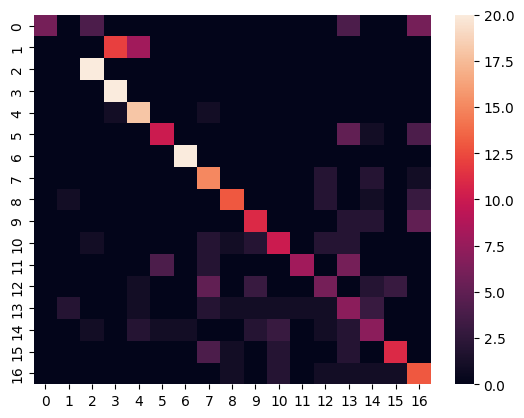

In [22]:
shape = outputs[0].shape
labels = torch.hstack(label_)
cnnresult = torch.vstack(outputs).reshape(-1,shape[0],shape[1]).mean(axis=0).to('cpu')
_, cnnPredicted = torch.max(cnnresult.data, 1)
cnnCorrect = (cnnPredicted.detach().numpy() == labels.to('cpu').detach().numpy()).sum().item()
print(cnnCorrect/len(labels)*100)
from sklearn.metrics import confusion_matrix
confu_m = confusion_matrix(labels.to('cpu'), cnnPredicted.to('cpu'))
import seaborn as sns
sns.heatmap(confu_m,square=False)

In [23]:
# Show the Precision, Recall, F1 scores of each classes
from sklearn.metrics import precision_recall_fscore_support
import pandas as pd
scores = pd.DataFrame(precision_recall_fscore_support(cnnPredicted.to('cpu'), labels.to('cpu'), labels = list(range(18))),index=['precision','recall','f1','support'], columns = list(label_dict)[:18])
scores

D:\programing\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programing\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Ambient,Blues,Children,Classical,Country,Electronic,Folk,Jazz,Latin,Pop,Rap,Reggae,Religious,Rock,Soul,Soundtracks,Unknown,World
precision,0.300000,0.0,1.000000,1.000000,0.90,0.500000,1.000000,0.750000,0.650000,0.550000,0.500000,0.400000,0.300000,0.350000,0.350000,0.550000,0.0,0.65000
recall,1.000000,0.0,0.769231,0.606061,0.60,0.666667,0.952381,0.483871,0.764706,0.578947,0.555556,0.888889,0.400000,0.225806,0.368421,0.733333,0.0,0.40625
f1,0.461538,0.0,0.869565,0.754717,0.72,0.571429,0.975610,0.588235,0.702703,0.564103,0.526316,0.551724,0.342857,0.274510,0.358974,0.628571,0.0,0.50000
support,6.000000,3.0,26.000000,33.000000,30.00,15.000000,21.000000,31.000000,17.000000,19.000000,18.000000,9.000000,15.000000,31.000000,19.000000,15.000000,0.0,32.00000


In [24]:
# Print the label_dict
label_dict = {}
for cl in le.classes_:
    label_dict.update({cl:le.transform([cl])[0]})
label_dict

{'Ambient': 0,
 'Blues': 1,
 'Children': 2,
 'Classical': 3,
 'Country': 4,
 'Electronic': 5,
 'Folk': 6,
 'Jazz': 7,
 'Latin': 8,
 'Pop': 9,
 'Rap': 10,
 'Reggae': 11,
 'Religious': 12,
 'Rock': 13,
 'Soul': 14,
 'Soundtracks': 15,
 'Unknown': 16,
 'World': 17}